In [22]:
import re
from pathlib import Path
from typing import Union, List
import numpy as np
import matplotlib.pyplot as plt

In [23]:
_COL_SEP = re.compile(r"\s{2,}")
def _split_cols(line: str) -> List[str]:
    return _COL_SEP.split(line.strip())

def read_unfiltered_column(path: Union[str, Path],
                           column: Union[str, int] = "Core cyc") -> np.ndarray:
    """
    Read a numeric column from the === UNFILTERED DATA section.

    Parameters
    ----------
    path : str or Path
        Path to the file.
    column : str or int
        Column name (e.g., "Core cyc") or column index (0-based).

    Returns
    -------
    np.ndarray
        Array of integers from the specified column.
    """
    path = Path(path)
    in_section = False
    header = None
    data: list[int] = []

    with path.open("r", encoding="utf-8") as fh:
        for raw in fh:
            if "=== UNFILTERED DATA" in raw:
                in_section = True
                continue
            if in_section and raw.startswith("==="):
                break
            if not in_section:
                continue

            if header is None and ("Clock" in raw or "Core" in raw):
                header = _split_cols(raw)
                continue

            if raw.strip() == "" or raw.startswith(("#", "-")):
                continue

            cols = _split_cols(raw)
            if header and len(cols) < len(header):
                continue

            if isinstance(column, str):
                if header is None or column not in header:
                    raise ValueError(f"Column '{column}' not found. Available: {header}")
                col_idx = header.index(column)
            else:
                col_idx = int(column)
                if col_idx >= len(cols):
                    raise IndexError(f"Column index {col_idx} out of range")

            try:
                data.append(int(float(cols[col_idx])))
            except ValueError:
                continue

    if not data:
        raise RuntimeError("No data captured—check file path/section/header.")

    return np.array(data, dtype=int)

def read_filtered_column(path: Union[str, Path],
                         column: Union[str, int] = "Core cyc") -> np.ndarray:
    """
    Read a numeric column from the '=== CORE CYC FILTERED DATA' section.

    Parameters
    ----------
    path : str or Path
        Path to the filtered_means.txt file.
    column : str or int
        Column name (e.g., "Core cyc", "res.stl.") or column index (0-based).

    Returns
    -------
    np.ndarray
        Integer values of the selected column.
    """
    path = Path(path)
    in_section = False
    header = None
    data: list[int] = []

    with path.open("r", encoding="utf-8") as fh:
        for line in fh:
            # Detect start of filtered data section
            if "=== CORE CYC FILTERED DATA" in line:
                in_section = True
                continue
            if in_section and header is None and ("Clock" in line or "Core" in line):
                header = _split_cols(line)
                continue
            if in_section and line.strip().startswith("---"):
                continue
            if in_section and line.startswith("==="):  # next section, stop
                break
            if not in_section:
                continue

            if line.strip() == "":
                continue

            cols = _split_cols(line)
            if header and len(cols) < len(header):
                continue

            if isinstance(column, str):
                if header is None or column not in header:
                    raise ValueError(f"Column '{column}' not found. Available: {header}")
                col_idx = header.index(column)
            else:
                col_idx = int(column)
                if col_idx >= len(cols):
                    raise IndexError(f"Column index {col_idx} out of range")

            try:
                data.append(int(float(cols[col_idx])))
            except ValueError:
                continue

    if not data:
        raise RuntimeError("No filtered data found. Check section or column.")

    return np.array(data, dtype=int)

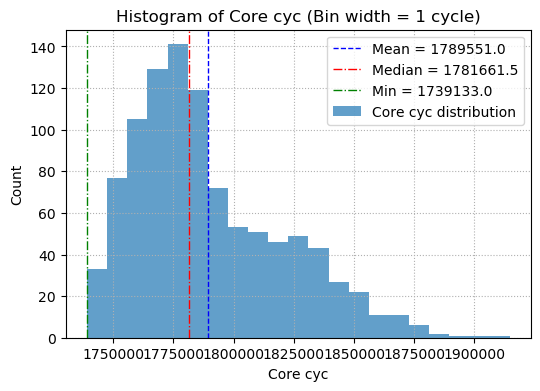

In [24]:
file_path = "filtered_means.txt"  

core_cyc = read_unfiltered_column(file_path, "Core cyc")

cc_mean_val   = core_cyc.mean()
cc_median_val = np.median(core_cyc)
cc_min_val = min(core_cyc)

plt.figure(figsize=(6, 4))  

# # Create bin edges to center bars on integer values
edges = np.arange(core_cyc.min(), core_cyc.max()+2, 1)

# plt.hist(core_cyc, bins=edges, alpha=0.7, label="Core cyc distribution")
plt.hist(core_cyc, bins='auto', alpha=0.7, label="Core cyc distribution")


plt.axvline(cc_mean_val,   linestyle="--", color='blue',linewidth=1,
            label=f"Mean = {cc_mean_val:.1f}")
plt.axvline(cc_median_val, linestyle="-.", color='red',linewidth=1,
            label=f"Median = {cc_median_val:.1f}")
plt.axvline(cc_min_val, linestyle="-.", color='green',linewidth=1,
            label=f"Min = {cc_min_val:.1f}")

plt.title("Histogram of Core cyc (Bin width = 1 cycle)")
plt.xlabel("Core cyc")
plt.ylabel("Count")
# plt.xticks(np.arange(core_cyc.min(), core_cyc.max() + 1, 1))
plt.grid(True, linestyle=":")
plt.legend()

# plt.xlim(auto=True)
# plt.ylim(0,10)
plt.show()


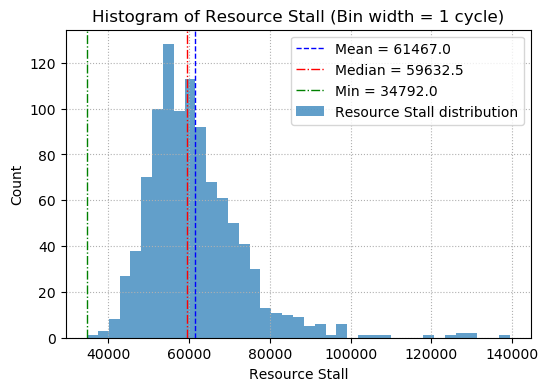

In [25]:
resource_stall    = read_unfiltered_column(file_path, "res.stl.")

rs_mean_val   = resource_stall.mean()
rs_median_val = np.median(resource_stall)
rs_min_val = min(resource_stall)

edges = np.arange(resource_stall.min(), resource_stall.max()+2, 1)

plt.figure(figsize=(6, 4))  

# plt.hist(resource_stall, bins=edges, alpha=0.7, label="Resource Stall distribution")
plt.hist(resource_stall, bins='auto', alpha=0.7, label="Resource Stall distribution")

plt.axvline(rs_mean_val,   linestyle="--", color='blue',linewidth=1,
            label=f"Mean = {rs_mean_val:.1f}")
plt.axvline(rs_median_val, linestyle="-.", color='red',linewidth=1,
            label=f"Median = {rs_median_val:.1f}")
plt.axvline(rs_min_val, linestyle="-.", color='green',linewidth=1,
            label=f"Min = {rs_min_val:.1f}")

plt.title("Histogram of Resource Stall (Bin width = 1 cycle)")
plt.xlabel("Resource Stall")
plt.ylabel("Count")
# plt.xticks(np.arange(core_cyc.min(), core_cyc.max() + 1, 1))
plt.grid(True, linestyle=":")
plt.legend()
# plt.xlim(auto=True)
# plt.xlim(core_cyc.min(), core_cyc.max())
plt.show()


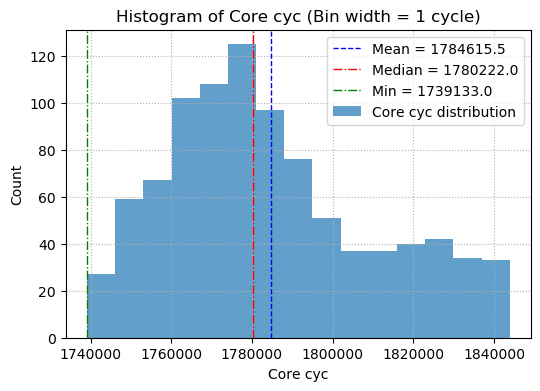

In [26]:
file_path = "filtered_means.txt"  

core_cyc = read_filtered_column(file_path, "Core cyc")

cc_mean_val   = core_cyc.mean()
cc_median_val = np.median(core_cyc)
cc_min_val = min(core_cyc)


# # Create bin edges to center bars on integer values
edges = np.arange(core_cyc.min(), core_cyc.max()+2, 1)

plt.figure(figsize=(6, 4))  

# plt.hist(core_cyc, bins=edges, alpha=0.7, label="Core cyc distribution")
plt.hist(core_cyc, bins='auto', alpha=0.7, label="Core cyc distribution")

plt.axvline(cc_mean_val,   linestyle="--", color='blue',linewidth=1,
            label=f"Mean = {cc_mean_val:.1f}")
plt.axvline(cc_median_val, linestyle="-.", color='red',linewidth=1,
            label=f"Median = {cc_median_val:.1f}")
plt.axvline(cc_min_val, linestyle="-.", color='green',linewidth=1,
            label=f"Min = {cc_min_val:.1f}")

plt.title("Histogram of Core cyc (Bin width = 1 cycle)")
plt.xlabel("Core cyc")
plt.ylabel("Count")
# plt.xticks(np.arange(core_cyc.min(), core_cyc.max() + 1, 1))
plt.grid(True, linestyle=":")
plt.legend()

# plt.xlim(auto=True)
# plt.ylim(0,10)
plt.show()


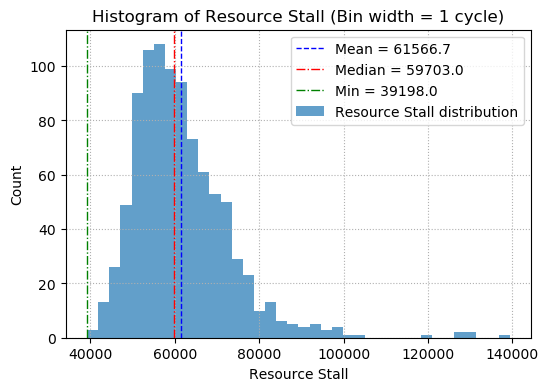

In [27]:
resource_stall    = read_filtered_column(file_path, "res.stl.")

rs_mean_val   = resource_stall.mean()
rs_median_val = np.median(resource_stall)
rs_min_val = min(resource_stall)

edges = np.arange(resource_stall.min(), resource_stall.max()+2, 1)

plt.figure(figsize=(6, 4))  

# plt.hist(resource_stall, bins=edges, alpha=0.7, label="Resource Stall distribution")
plt.hist(resource_stall, bins='auto', alpha=0.7, label="Resource Stall distribution")

plt.axvline(rs_mean_val,   linestyle="--", color='blue',linewidth=1,
            label=f"Mean = {rs_mean_val:.1f}")
plt.axvline(rs_median_val, linestyle="-.", color='red',linewidth=1,
            label=f"Median = {rs_median_val:.1f}")
plt.axvline(rs_min_val, linestyle="-.", color='green',linewidth=1,
            label=f"Min = {rs_min_val:.1f}")

plt.title("Histogram of Resource Stall (Bin width = 1 cycle)")
plt.xlabel("Resource Stall")
plt.ylabel("Count")
# plt.xticks(np.arange(core_cyc.min(), core_cyc.max() + 1, 1))
plt.grid(True, linestyle=":")
plt.legend()
# plt.xlim(auto=True)
# plt.xlim(core_cyc.min(), core_cyc.max())
plt.show()
